In [1]:
import numpy as np
import random
import math
import tensorflow as tf
import matplotlib.pyplot as plt

Генерация данных

In [2]:
def generate_x_y_data_v1(isTrain, batch_size):
    # seq_length - длина предсказываемого временного ряда
    seq_length = 10
    
    batch_x = []
    batch_y = []
    for _ in range(batch_size): 
        # Одна итерация цикла генерирует 1 пакет данных 
        rand = random.random() * 2 * math.pi
        
        # Генерируем набор данных по заданному закону
        #np.linspace генерирует набор точек, равномерно распредленных по заданному интервалу 
        # (границы интервала смещены на случайную величину)
        sig1 = np.sin(np.linspace(0.0 * math.pi + rand, 3.0 * math.pi + rand,
                                  seq_length * 2))
        sig2 = np.cos(np.linspace(0.0 * math.pi + rand, 3.0 * math.pi + rand,
                                  seq_length * 2))
        
        # первую половину сигналов берем на обучающую выборку,
        # вторую - на контрольную
        x1 = sig1[:seq_length]
        y1 = sig1[seq_length:]
        x2 = sig2[:seq_length]
        y2 = sig2[seq_length:]
        
        x_ = np.array([x1, x2])
        y_ = np.array([y1, y2])
        x_, y_ = x_.T, y_.T
    
        batch_x.append(x_)
        batch_y.append(y_)
    
    batch_x = np.array(batch_x)
    batch_y = np.array(batch_y) 
    # транспонируем, чтобы привести к нужной размерности
    batch_x = np.array(batch_x).transpose((1, 0, 2))
    batch_y = np.array(batch_y).transpose((1, 0, 2)) 
    
    return batch_x , batch_y

In [3]:
# Данные имеют размерность (seq_length , batch_size , output_dim) 
sample_x, sample_y = generate_x_y_data_v1(isTrain=True, batch_size=3)

Определение параметров нейросети

In [4]:
# Длина последовательности (в данных примерах одинаковая для обучающих и тестовых данных)
seq_length = sample_x.shape[0] 

# Размер пакета количество(тестовых примеров), по которому усредняется градиент
batch_size = 5

# Размерность выходных данных 
output_dim = input_dim = sample_x.shape[-1]

# Количество скрытых нейронов в каждой ячейке
hidden_dim = 12

# Количество ячеек рекуррентной сети (в глубину)
layers_stacked_count = 2

In [5]:
sample_x

array([[[-0.36261013,  0.93194093],
        [ 0.99742976, -0.07165099],
        [ 0.63552499,  0.77208029]],

       [[ 0.12464877,  0.99220093],
        [ 0.8431112 , -0.53773926],
        [ 0.92639715,  0.37654789]],

       [[ 0.58186076,  0.81328842],
        [ 0.48555857, -0.87420414],
        [ 0.99395897, -0.10975233]],

       [[ 0.89881377,  0.4383307 ],
        [ 0.01096083, -0.99993993],
        [ 0.82192449, -0.56959647]],

       [[ 0.99910547, -0.04228772],
        [-0.46627904, -0.8846377 ],
        [ 0.45176306, -0.89213796]],

       [[ 0.85856031, -0.51271259],
        [-0.83112118, -0.55609134],
        [-0.02729699, -0.99962737]],

       [[ 0.51105703, -0.8595468 ],
        [-0.99561949, -0.09349778],
        [-0.49977702, -0.8661541 ]],

       [[ 0.04036219, -0.99918511],
        [-0.92012123,  0.39163366],
        [-0.85178456, -0.52389223]],

       [[-0.44006207, -0.89796736],
        [-0.62282545,  0.78236082],
        [-0.9984673 , -0.05534482]],

       [[-

In [7]:
# Параметры оптимизатора 
# Скорость обучения маленькая (скорость обучения позволяет алгоритму не расходиться во время обучения)
learning_rate = 0.007

# Количество итераций по обучающей выборке 
nb_iters = 150

# Дополнительные параметры алгоритма оптимизации
lr_decay = 0.92
momentum = 0.5

# Коэффициент L2 регуляризации
lambda_l2_reg = 0.003

In [8]:
tf.nn.seq2seq = tf.contrib.legacy_seq2seq
tf.nn.rnn_cell = tf.contrib.rnn
tf.nn.rnn_cell.GRUCell = tf.contrib.rnn.GRUCell

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [9]:
tf.reset_default_graph()
# интерактивная сессия
sess = tf.InteractiveSession()

Описание графа вычислений

In [10]:
with tf.variable_scope('Seq2seq'):
    enc_inp = [
        tf.placeholder(tf.float32, shape=(None, input_dim),
                       name="inp_{}".format(t)) for t in range(seq_length)
    ]
    #ожидаемые входы для декодировщика
    expected_sparse_output = [
        tf.placeholder(tf.float32, shape=(None, output_dim),
                       name="expected_sparse_output_".format(t))
            for t in range(seq_length)
    ]
    
    dec_inp = [tf.zeros_like(enc_inp[0],
                             dtype=np.float32, name="GO")] + enc_inp[:-1]
    #описание модели
    cells = []
    #формирование GRU ячеек
    #layers_stacked_count - количество GRU ячеек в модели
    for i in range(layers_stacked_count):
        with tf.variable_scope('RNN_{}'.format(i)):
            cells.append(tf.nn.rnn_cell.GRUCell(hidden_dim))
            
    cell = tf.nn.rnn_cell.MultiRNNCell(cells)
    #кодировщик, input_dim , hidden_dim - размерность входных и внутренних данных
    w_in = tf.Variable(tf.random_normal([input_dim , hidden_dim]))
    b_in = tf.Variable(tf.random_normal([hidden_dim], mean=1.0))
    #декодировщик
    w_out = tf.Variable(tf.random_normal([hidden_dim , output_dim]))
    b_out = tf.Variable(tf.random_normal([output_dim]))

    reshaped_inputs = [tf.nn.relu(tf.matmul(i, w_in) + b_in) for i in enc_inp]
    #определение модели
    dec_outputs, dec_memory = tf.nn.seq2seq.basic_rnn_seq2seq(
        enc_inp,
        dec_inp,
        cell
    )
    
    output_scale_factor = tf.Variable(1.0, name="Output_ScaleFactor")
    reshaped_outputs = [output_scale_factor * (tf.matmul(i, w_out) + b_out) for i in dec_outputs]


Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Описание функции потерь

In [11]:
with tf.variable_scope('Loss'):
    # используется L2 loss
    output_loss = 0
    for _y, _Y in zip(reshaped_outputs, expected_sparse_output):
        output_loss += tf.reduce_mean(tf.nn.l2_loss(_y - _Y))

    # слагаемое, отвечающее за L2 регуляризацию
    reg_loss = 0
    for tf_var in tf.trainable_variables():
        if not ("Bias" in tf_var.name or "Output_" in tf_var.name):
            reg_loss += tf.reduce_mean(tf.nn.l2_loss(tf_var))

    loss = output_loss  + lambda_l2_reg * reg_loss


Описание оптимизатора

In [12]:
#используется RMSProp
with tf.variable_scope('Optimizer'):
    optimizer = tf.train.RMSPropOptimizer(learning_rate, decay=lr_decay, momentum=momentum)
    train_op = optimizer.minimize(loss)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Обучение и валидация НС

In [13]:
# Шаг обучения, который оптимизирует веса в соответствии с переданным минипакетом-примеров
def train_batch(batch_size):
    X, Y = generate_x_y_data_v1(isTrain=True , batch_size=batch_size)
    feed_dict = {enc_inp[t]: X[t] for t in range(len(enc_inp))} 
    feed_dict.update({expected_sparse_output[t]: Y[t] for t in range(len(expected_sparse_output))}) 
    #  запускаем сессию. При этом рассчитываются тензоры, указанные в первом параметре, 
    # а значения для них берутся из второго параметра
    _, loss_t = sess.run([train_op , loss], feed_dict)
    
    return loss_t

In [14]:
#тестовый прогон
def test_batch(batch_size): 
    X, Y = generate_x_y_data_v1(isTrain=False, batch_size=batch_size)
    feed_dict = {enc_inp[t]: X[t] for t in range(len(enc_inp))}
    feed_dict.update({expected_sparse_output[t]: 
                      Y[t] for t in range(len(expected_sparse_output))}) 
    loss_t = sess.run([loss], feed_dict)
    return loss_t[0]
   

In [15]:
train_losses = []
test_losses = []

sess.run(tf.global_variables_initializer())
# nb_iters - количество шагов для обучения.
# После каждых 10 шагов проверяется ошибка на тестовой выборке

for t in range(nb_iters+1):
    train_loss = train_batch(batch_size)
    train_losses.append(train_loss)

    if t % 10 == 0:
        test_loss = test_batch(batch_size)
        test_losses.append(test_loss)
        print("Step {}/{}, \t train loss: {}, \t TEST loss: {}".format(t,
                                                                   nb_iters,
                                                                   train_loss,
                                                                   test_loss))

print("Fin. train loss: {}, \tTEST loss: {}".format(train_loss, test_loss))

Step 0/150, 	 train loss: 26.808124542236328, 	 TEST loss: 21.379825592041016
Step 10/150, 	 train loss: 3.6146395206451416, 	 TEST loss: 4.041858673095703
Step 20/150, 	 train loss: 0.7621623277664185, 	 TEST loss: 0.8466287851333618
Step 30/150, 	 train loss: 0.6079262495040894, 	 TEST loss: 0.6721744537353516
Step 40/150, 	 train loss: 1.0062415599822998, 	 TEST loss: 0.6992576718330383
Step 50/150, 	 train loss: 0.5933796167373657, 	 TEST loss: 0.7633225321769714
Step 60/150, 	 train loss: 0.6269983649253845, 	 TEST loss: 0.5288141965866089
Step 70/150, 	 train loss: 1.0649940967559814, 	 TEST loss: 1.0154097080230713
Step 80/150, 	 train loss: 0.5237476825714111, 	 TEST loss: 0.576218843460083
Step 90/150, 	 train loss: 0.6290964484214783, 	 TEST loss: 0.6060156226158142
Step 100/150, 	 train loss: 0.46883925795555115, 	 TEST loss: 0.46981123089790344
Step 110/150, 	 train loss: 1.6622614860534668, 	 TEST loss: 1.1195199489593506
Step 120/150, 	 train loss: 0.4524778723716736, 	 T

Визуализация процесса обучения

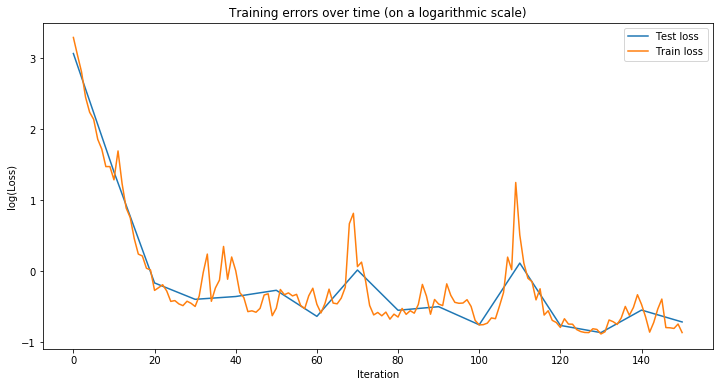

In [16]:
#построение функции потерь
plt.figure(figsize=(12, 6))
plt.plot( 
        np.array(range(0, len(test_losses)))/float(len(test_losses)-1) * (len(train_losses)-1), 
        np.log(test_losses), 
        label="Test loss" 
)
plt.plot( 
        np.log(train_losses), 
        label="Train loss" 
)
plt.title("Training errors over time (on a logarithmic scale)") 
plt.xlabel('Iteration')
plt.ylabel('log(Loss)') 
plt.legend(loc='best') 
plt.show()

Визуализация результата

Let 's visualize 1 predictions with our signals :


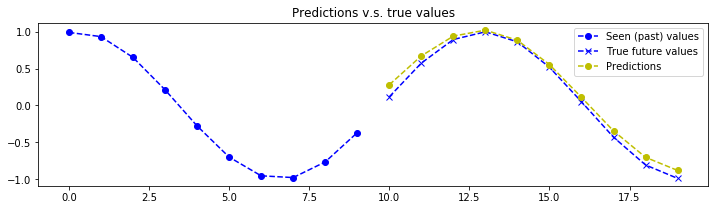

In [17]:
nb_predictions = 1
print("Let 's visualize {} predictions with our signals :".format(nb_predictions))

X, Y = generate_x_y_data_v1(isTrain=False, batch_size = nb_predictions)
feed_dict = { enc_inp [t]: X[t] for t in range(seq_length)}
outputs = np.array(sess.run([reshaped_outputs], feed_dict)[0])

# выводим предсказания по каждому пакету
for j in range(nb_predictions):
    plt.figure(figsize=(12, 3))
      
    for k in range(output_dim):
        past = X[:,j,k]
        expected = Y[:,j,k]
        pred = outputs [:,j,k]
      
    label1 = "Seen (past) values" 
    label2 = "True future values"
    label3 = "Predictions"
      
    plt.plot(range(len(past)), past, "o--b", label = label1)
    plt.plot(range(len(past), len(expected) + len(past)), expected, "x--b", label = label2)
    plt.plot(range(len(past), len(pred) + len(past)), pred, "o--y", label = label3 )
      
    plt.legend(loc ='best')
    plt.title("Predictions v.s. true values")
    plt.show()